Student's Name and Email Address

Boise State University, Department of Chemistry and Biochemistry

## CHEM 324: PChem Lab {-}
# Worksheet 3: Bomb Calorimetry {-}

In [23]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import sem, t, norm

base_path = '/Users/School/PycharmProjects/PChemLab/Bomb_Data/Bomb Cal'

In [24]:
# @title Utilities { display-mode: "form" }
# Functions designed for loading, analyzing, and fitting the bomb calorimetry data
def get_sec(time_str):
    """
    Convert a time string in HH:MM:SS format into an integer number of seconds

    Input variables:
        time_str : a string with a time in HH:MM:SS format

    Output:
        time : the integer number of seconds corresponding to the input time_str
    """
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

def load_data_to_file_dict(file_dict):
    """
    Load a bomb calorimetry .csv file.
    The format of the file should have the first column with time in HH:MM:SS format and
    the second column with the recorded temperature. Any additional column is discarded

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded

    Action:
        Add to file_dict a Pandas DataFrame with two columns: time (in seconds) and temperature (in input units)
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],usecols=(0,2),names=['hh:mm:ss','temperature'])
    data['time'] = data['hh:mm:ss'].apply(get_sec)
    data = data.drop(columns=['hh:mm:ss'])
    file_dict['data'] = data
    return

def load_data_to_file_list(file_list):
    """
    Given a list of dictionary files, recursively use load_data_to_file_dict to load the data into each of the dictionaries

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded

    Action:
        Add to each file_dict a Pandas DataFrame with two columns: time (in seconds) and temperature (in input units)
    """
    for f in file_list :
        if not ('data' in f): load_data_to_file_dict(f)
    return

def plot_file_dict(file_dict):
    """
    Given a dictionary file of a bomb calorimetry experiment, plot temperature vs. time.

    Input variables:
        file_dict : a dictionary file with 'path' and 'name' keys corresponding to the file to be loaded

    Action:
        Plot temperature vs. time for the selected file
    """
    fig, ax = plt.subplots()
    if not ('data' in file_dict):
        load_data_to_file_dict(f)
    file_dict['data'].plot('time','temperature',label=file_dict['name'],ax=ax)
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature ($^{\circ}$C)')
    plt.show()

def plot_by_key(file_list,key='',value=['']):
    """
    Given a list of dictionary files, plot temperature vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files

    Action:
        Plot temperature vs. time for the selected files
    """
    if value == '' or key == '':
        file_shortlist = file_list
    else :
        file_shortlist = [f for f in file_list if f[key] in value ]
    fig, ax = plt.subplots()
    for f in file_shortlist :
        if not ('data' in f):
            load_data_to_file_dict(f)
        f['data'].plot('time','temperature',label=f['name'],ax=ax)
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature ($^{\circ}$C)')
    plt.show()

def get_time_skip(file_dict,recursive = False):
    if not ('data' in file_dict) :
        load_data_to_file_dict(file_dict)
    if file_dict['time_skip'] == 0 :
        time_skip = 0
    else:
        time_skip = file_dict['time_skip']
    data = file_dict['data']
    clean_data = data[data['time']>time_skip]
    if recursive :
        return time_skip, clean_data
    else :
        return time_skip

def get_time_ignition(file_dict,recursive = False):
    time_skip, data = get_time_skip(file_dict,True)
    if file_dict['time_ignition'] == 0:
        temperatures=data['temperature'].values
        times=data['time'].values
        derivatives = np.zeros(temperatures.shape)
        derivatives[1:-1] = np.convolve(temperatures,[1,-2,1],'same')[1:-1]
        ignition_index = np.argmax(derivatives)
        time_ignition = times[ignition_index-1]
    else :
        time_ignition = file_dict['time_ignition']
    if recursive :
        return time_skip, time_ignition, data
    else :
        return time_ignition

def get_time_exponential(file_dict,recursive = False):
    time_skip, time_ignition, data = get_time_ignition(file_dict, True)
    if file_dict['time_exponential'] == 0:
        times = data['time'].values
        temperatures = data['temperature'].values
        time_exponential = times[np.argmax(temperatures)]
    else :
        time_exponential = file_dict['time_exponential']
    if recursive :
        return time_skip, time_ignition, time_exponential, data
    else :
        return time_exponential

def get_time_post(file_dict, recursive = False):
    time_skip, time_ignition, time_exponential, data = get_time_exponential(file_dict, True)
    if file_dict['time_post'] == 0 :
        temperatures = data['temperature'].values
        exponential_data = data.query('time > {} and time < {}'.format(time_ignition,time_exponential))
        exponential_lr = LinearRegression()
        exp_x = exponential_data['time'].values.reshape(-1,1)
        exp_y = np.log(np.max(temperatures) - exponential_data['temperature'].values)
        exponential_lr.fit(exp_x,exp_y)
        rate = -exponential_lr.coef_[0]
        time_post = time_ignition + 6/rate
        if time_post > data['time'].iloc[-1] :
            # if we overshoot time_post, just choose six points to fit the postignition linear drift
            time_post = data['time'].iloc[-6]
    else :
        time_post = file_dict['time_post']
    if recursive :
        return time_skip, time_ignition, time_exponential, time_post, data
    else :
        return time_post

def get_deltaT(file_dict,verbose=False,plot=False):

    time_skip, time_ignition, time_exponential, time_post, data = get_time_post(file_dict,True)

    times = data['time'].values
    temperatures = data['temperature'].values
    if plot :
        plt.plot(times,temperatures)
        plt.ylabel('Temperature ($^{\circ}$C)')
        plt.xlabel('Time (s)')

    preignition_data = data[ data['time'] < time_ignition ]
    preignition_lr = LinearRegression()
    pre_x = preignition_data['time'].values.reshape(-1,1)
    pre_y = preignition_data['temperature'].values
    preignition_lr.fit(pre_x,pre_y)
    Ti = preignition_lr.predict([[time_ignition]])[0]
    temperatures_preignition = preignition_lr.predict(times.reshape(-1,1))
    if plot : plt.plot(times,temperatures_preignition,':',color='k')

    exponential_data = data.query('time >= {} and time < {}'.format(time_ignition,time_exponential))
    Te = np.max(data['temperature'])
    exponential_lr = LinearRegression()
    exp_x = exponential_data['time'].values.reshape(-1,1)
    exp_y = np.log(Te - exponential_data['temperature'].values)
    exponential_lr.fit(exp_x,exp_y)
    rate = -exponential_lr.coef_[0]
    time_determination = time_ignition + 1/rate
    temperatures_exponential = Te - np.exp(exponential_lr.predict(exp_x))
    if plot : plt.plot(exp_x,temperatures_exponential,':',color='k')

    postignition_data = data[ data['time'] > time_post ]
    postignition_lr = LinearRegression()
    post_x = postignition_data['time'].values.reshape(-1,1)
    post_y = postignition_data['temperature'].values
    postignition_lr.fit(post_x,post_y)
    Tf = postignition_lr.predict([[time_post]])[0]
    temperatures_postignition = postignition_lr.predict(times.reshape(-1,1))
    if plot : plt.plot(times,temperatures_postignition,':',color='k')

    Tmax = np.max(temperatures)
    tmax = times[np.argmax(temperatures)]
    Tmin = np.min(temperatures)
    tmin = times[np.argmin(temperatures)]
    deltaT_max = Tmax - Tmin
    if verbose and plot :
        plt.plot([tmax,tmin],[Tmax,Tmin],'o',color = 'C3')
        plt.plot([tmin,tmax],[Tmin,Tmin],':',color = 'C3')
        plt.plot([tmax,tmax],[Tmin,Tmax],color = 'C3')

    deltaT = Tf - Ti
    if verbose and plot :
        plt.plot([time_ignition,time_post],[Ti,Tf],'o',color='C1')
        plt.plot([time_ignition,time_post],[Ti,Ti],':',color='C1')
        plt.plot([time_post,time_post],[Ti,Tf],color='C1')

    Ti_corrected = preignition_lr.predict(np.array([[time_determination]]))[0]
    Tf_corrected = postignition_lr.predict(np.array([[time_determination]]))[0]
    deltaT_corrected = Tf_corrected - Ti_corrected
    if plot : plt.plot(np.ones(2)*time_determination,[Ti_corrected,Tf_corrected],'o-',color='k')
    if verbose :
        print("The corrected deltaT is {:7.4f}\nThe uncorrected deltaT is {:7.4f}\nThe maximum deltaT from the data is {:7.4f}".format(deltaT_corrected, deltaT, deltaT_max))
        return
    else :
        return deltaT_corrected

<>:63: SyntaxWarning: invalid escape sequence '\c'
<>:89: SyntaxWarning: invalid escape sequence '\c'
<>:164: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\c'
<>:89: SyntaxWarning: invalid escape sequence '\c'
<>:164: SyntaxWarning: invalid escape sequence '\c'
/var/folders/5z/b4d9cm852hzgsg3w_2h1vqnc0000gp/T/ipykernel_30827/3389530967.py:63: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Temperature ($^{\circ}$C)')
/var/folders/5z/b4d9cm852hzgsg3w_2h1vqnc0000gp/T/ipykernel_30827/3389530967.py:89: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Temperature ($^{\circ}$C)')
/var/folders/5z/b4d9cm852hzgsg3w_2h1vqnc0000gp/T/ipykernel_30827/3389530967.py:164: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Temperature ($^{\circ}$C)')


In [25]:

path = '/Users/School/PycharmProjects/PChemLab/Bomb_Data/Bomb Cal/'

## Task 1: Calibration {-}

In the lab you performed a series of experiments with a known compound for which you know the enthalpy of combustion. You should have analyzed at least three samples of the benzoic acid standard (abbreviated to BA in the following) to determine the standard deviation in your calorimeter constant.

* Visually inspect each of your calibration curves, one by one. For each curve establish the time from which to start the fit of the data (`time_skip`), the time at which the ignition occurs (`time_ignition`), a good time to fit the exponential decay (`time_exponential`), and the time at which the cuve becomes linear again (`time_post`).

In [26]:
# make sure to put the names of your actual files and the correct numbers as obtained from visual inspection of your data
ba_file1 = {'path':path, 'name':'BA1.txt', 'set':'calibration', 'mass':1.0119, 'time_skip':220, 'time_ignition': 240, 'time_exponential': 260, 'time_post': 590}
ba_file2 = {'path':path, 'name':'BA2.txt', 'set':'calibration', 'mass':1.0172, 'time_skip':130, 'time_ignition': 150, 'time_exponential': 165, 'time_post': 520}
ba_file3 = {'path':path, 'name':'BA3.txt', 'set':'calibration', 'mass':1.0002, 'time_skip':35, 'time_ignition': 50, 'time_exponential': 70, 'time_post': 390}
#
calibration_files=[ba_file1,ba_file2,ba_file3] # if you have more  than three calibration runs, add the other files in here as well!
load_data_to_file_list(calibration_files)

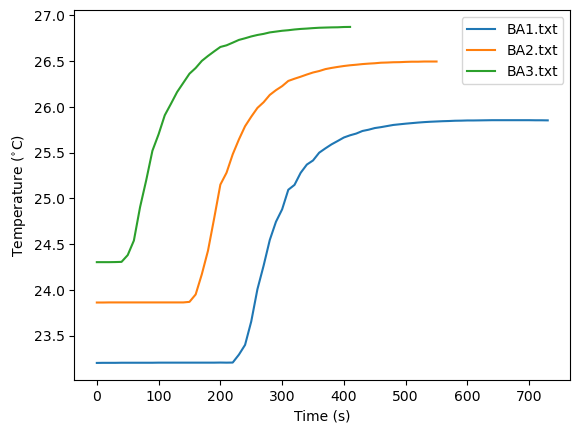

In [27]:
plot_by_key(calibration_files)

* Fit the calorimetry curves for the calibration runs and collect the corresponding temperature jumps. 

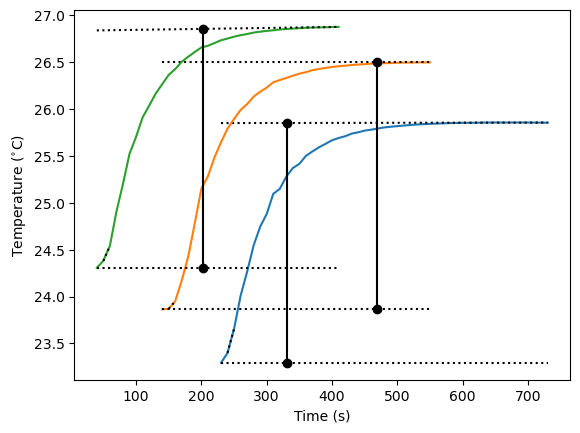

In [28]:
for file_dict in calibration_files:
    # this computes the deltaT for each run
    file_dict['deltaT'] = get_deltaT(file_dict,plot=True)

* Use the measured weights and the molar weight of BA to convert the temperature jumps into estimated calorimeter constants. Use error propagation to estimate the error in each computed constant. 

In [29]:
# You can now convert your list of dictionaries into a Pandas DataFrame, so you can perform math operations on each experiment at once
calibration_data=pd.DataFrame(calibration_files)
calibration_data.head()

,path,name,set,mass,time_skip,time_ignition,time_exponential,time_post,data,deltaT
0,/Users/School/PycharmProjects/PChemLab/Bomb_Da...,BA1.txt,calibration,1.0119,220,240,260,590,temperature time 0 23.203 0 1 ...,2.557326
1,/Users/School/PycharmProjects/PChemLab/Bomb_Da...,BA2.txt,calibration,1.0172,130,150,165,520,temperature time 0 23.863 0 1 ...,2.632000
2,/Users/School/PycharmProjects/PChemLab/Bomb_Da...,BA3.txt,calibration,1.0002,35,50,70,390,temperature time 0 24.304 0 1 ...,2.546174


In [30]:
cs = 0. # This should be the correct value of the specific heat capacity of your benzoic acid standard, in the correct units

In [31]:
# this is an example on how to perform math in Pandas with the same formula applied to each of your experiments
# NOTE: this may NOT be the correct formula to use for your data
calibration_data['Calorimetry Constant']=cs*calibration_data['mass']/calibration_data['deltaT']

* Report the masses of the samples, the corresponding temperature jumps, calorimetry constants, and estimated errors into a table with the correct units. 

In [32]:
# you can use the DataFrame.to_markdown() function to first generate a markdown table
print(calibration_data[['mass','deltaT','Calorimetry Constant']].to_markdown())

|    |   mass |   deltaT |   Calorimetry Constant |
|---:|-------:|---------:|-----------------------:|
|  0 | 1.0119 |  2.55733 |                      0 |
|  1 | 1.0172 |  2.632   |                      0 |
|  2 | 1.0002 |  2.54617 |                      0 |


That you can cut and paste into a markdown cell. NOTE: you can manually change some parts of the table to make it more pretty, add units, or to adjust the number of significant figures.

| Sample |   Mass (g) |   $\Delta T$ (&deg;C) |   C |
|---:|-------:|---------:|----:|
|  1 |      0 |  2.72093 |  -0 |
|  2 |      0 |  2.63378 |  -0 |
|  3 |      0 |  2.63627 |  -0 |

* Determine the best estimate of the calorimeter constant for your instrument, with error using t-stats and a 95% confidence level.

In [33]:
C=0.
C_error_ci95=0.
print(f"The calorimeter constant is {C} \u00B1 {C_error_ci95}")

The calorimeter constant is 0.0 ± 0.0


## Task 2: Internal Energy of Combustion of 1,4-Cyclohexane Dicarboxylic Acid {-}

Your second set of experiments was aimed at collecting the internal energy of combustion of 1,4-Cyclohexane Dicarboxylic Acid (abbreviated to CHex in the following). 

* Fit the calorimetry curves to determine the temperature jumps in the experiments.

In [34]:
# make sure to put the names of your actual files and the correct numbers as obtained from visual inspection of your data
chex_file1 = {'path':path, 'name':'Gel1.csv', 'set':'calibration', 'mass':0., 'time_skip':0, 'time_ignition': 0, 'time_exponential': 0, 'time_post': 0}
chex_file2 = {'path':path, 'name':'Gel2.csv', 'set':'calibration', 'mass':0., 'time_skip':0, 'time_ignition': 0, 'time_exponential': 0, 'time_post': 0}
chex_file3 = {'path':path, 'name':'Gel3.csv', 'set':'calibration', 'mass':0., 'time_skip':0, 'time_ignition': 0, 'time_exponential': 0, 'time_post': 0}
#
chex_files=[chex_file1,chex_file2,chex_file3] # if you have more than three CHex runs, add the other files in here as well!
load_data_to_file_list(chex_files)
#
for file_dict in chex_files:
    # this computes the deltaT for each run
    file_dict['deltaT'] = get_deltaT(file_dict,plot=True)

/var/folders/5z/b4d9cm852hzgsg3w_2h1vqnc0000gp/T/ipykernel_30827/3389530967.py:63: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Temperature ($^{\circ}$C)')
/var/folders/5z/b4d9cm852hzgsg3w_2h1vqnc0000gp/T/ipykernel_30827/3389530967.py:89: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Temperature ($^{\circ}$C)')
/var/folders/5z/b4d9cm852hzgsg3w_2h1vqnc0000gp/T/ipykernel_30827/3389530967.py:164: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Temperature ($^{\circ}$C)')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/School/PycharmProjects/PChemLab/Bomb_Data/Bomb Cal/Gel1.csv'

* Using the calorimetry constant computed in the previous task, calculate the heat of the reaction for the three samples.

In [ ]:
# write your math here

* Using the masses of the samples and the molar weight of CHex, compute the change in internal energy per mole of reaction for each sample. Report the masses, temperature jumps, heat of rection and internal energy change in a table with the appropriate units.  

In [ ]:
# write your math here

* Determine the best estimate of the internal energy change per mole of reaction, with error using t-stats and a 95% confidence level.

In [ ]:
UCHex=0.
UCHex_error_ci95=0.
print(f"The internal energy of combustion of CHex is {UCHex} \u00B1 {UCHex_error_ci95}")

## Task 3: Enthalpy of Combustion of Cyclopropane Carboxylic Acid {-}

Your last set of experiments was aimed at collecting the internal energy of combustion of Cyclopropane Carboxylic Acid (abbreviated to CPro in the following). 

* Using the weights of your samples and the molar weight of CPro, together with the calorimetry constant in the previous step, convert your measures into changes of internal energy.

In [ ]:
# make sure to put the names of your actual files and the correct numbers as obtained from visual inspection of your data
cpro_file1 = {'path':path, 'name':'CP1.csv', 'set':'calibration', 'mass':0., 'time_skip':0, 'time_ignition': 0, 'time_exponential': 0, 'time_post': 0}
cpro_file2 = {'path':path, 'name':'CP2.csv', 'set':'calibration', 'mass':0., 'time_skip':0, 'time_ignition': 0, 'time_exponential': 0, 'time_post': 0}
cpro_file3 = {'path':path, 'name':'CP3.csv', 'set':'calibration', 'mass':0., 'time_skip':0, 'time_ignition': 0, 'time_exponential': 0, 'time_post': 0}
#
cpro_files=[cpro_file1,cpro_file2,cpro_file3] # if you have more than three CPro runs, add the other files in here as well!
load_data_to_file_list(cpro_files)
#
for file_dict in cpro_files:
    # this computes the deltaT for each run
    file_dict['deltaT'] = get_deltaT(file_dict,plot=True)

* Using the calorimetry constant computed in the previous task, calculate the heat of the reaction for the three samples.

In [ ]:
# write your math here

* Using the masses of the samples and the molar weight of CPro, compute the change in internal energy per mole of reaction for each sample. Report the masses, temperature jumps, heat of rection and internal energy change in a table with the appropriate units.  

In [ ]:
# write your math here

* Determine the best estimate of the internal energy change per mole of reaction, with error using t-stats.

In [ ]:
UCPro=0.
UCPro_error_ci95=0.
print(f"The internal energy of combustion of CPro is {UCPro} \u00B1 {UCPro_error_ci95}")

## Task 4: Enthalpies of Combustion and Ring Strain Energy {-}

By comparing the two sets of experiments you should be able to estimate how much energy is involved in the formation of small rings. The following questions will only require you to compare results from the steps above.

* Convert the internal energy change into enthalpy using the equation provided in the handouts: 
$\Delta H = \Delta U + \Delta n RT$
and report the best estimate of the combustion enthalpy at $25^{\circ}$ C for CHex and CPro, with their associated errors.
* Compare your resultd with the literature values, comment on your percent error and on the possible sources of deviation from the literature.

In [ ]:
# your math here

We can define the ring strain energy based on the chemical equation for conversion of CHex into CPro. 
* Do you expect this conversion to be endothermic or exothermic? Comment on the sign of the ring strain energy you expect for this reaction. 
* Compute your best estimate of the ring strain energy and its associated error.

In [ ]:
RingStrain = 0.
RingStrain_error = 0.
print("The best estimate for the ring strain energy is {}".format(RingStrain))
print("The standard error associated with this estimate is {}".format(RingStrain_error))

* Report a graph for at least one combustion run for both CHex and CPro. These should be placed in the same graph with axes properly labeled. 

In [ ]:
# Be creative in your graphs! 

In [ ]:
# This cell is used to allow Google Colab to install the tools to convert the notebook to a pdf file
# Un-comment the following lines when you are ready to export the pdf 
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc

In [ ]:
# Use this command to convert the finished worksheet into a pdf 
# NOTE : you may want to change the path of the file, if you are working in a different folder of the Google Drive
#!jupyter nbconvert --no-input --to PDF "/content/drive/MyDrive/Colab Notebooks/Bomb_Worksheet.ipynb"